# The Carpentries: Accessing GES DISC Data With Python

Author: Chris Battisto (christopher.m.battisto@nasa.gov)

Attendee:

### Overview

This notebook demonstrates accessing and analyzing [Sentinel-5P TROPOMI NO2](https://disc.gsfc.nasa.gov/datasets/S5P_L2__NO2____HiR_1/summary) data using Python, accessed from the [NASA GES DISC](https://disc.gsfc.nasa.gov/datasets?page=1) archives. It demonstrates querying [OPeNDAP](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap) URLs of the granules using the shortname and desired spatio-temporal range from the [Content Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). Next, we demonstrate how to use Python to open and subset the OPeNDAP URLs, before analyses are performed.


### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
    - Approval of the "NASA GESDISC DATA ARCHIVE" application by following this guide: https://disc.gsfc.nasa.gov/earthdata-login
    - Generation of the `.netrc` and `.dodsrc` files (both files will be generated in this notebook)
- Python >=3.7
- [Xarray](https://docs.xarray.dev/en/stable/)
- [Pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [NumPy](https://numpy.org/)
- [python-cmr](https://github.com/nasa/python_cmr)
- [earthaccess](https://github.com/nsidc/earthaccess)


You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://github.com/nasa/gesdisc-tutorials/tree/main/webinars/14_November_2023_Carpentries_Skill-Up/November_14th_Carpentries_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 1. Install Packages and Import Libraries

In [ ]:
! pip3 install earthaccess xarray python-cmr netcdf4 harmony-py cartopy

In [2]:
import earthaccess
import xarray as xr
import numpy as np
import pandas as pd
import cmr
import os
import platform
from subprocess import Popen
import shutil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import concurrent.futures

%matplotlib inline

## 2. Create Earthdata Login "Prerequisite" Files

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file. See https://github.com/nsidc/earthaccess for more details.

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True)

Next, run the following code to generate the `.dodsrc` file, if it is not already present:

In [4]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .dodsrc to: /root/


### 3. Query Granules from the Content Metadata Repository

In [5]:
opendap_links_2019 = []

# Initialize the CMR search API
api = cmr.GranuleQuery()

# Define the time range
start_time = "2019-03-15T00:00:00Z"
end_time = "2019-04-01T23:59:59Z"

# Search for granules with the specific short name, version, time range, and bounding box
granules = (
    api.short_name('S5P_L2__NO2____HiR')
    .version('2')
    .temporal(start_time, end_time)
    .bounding_box(-88, 41.6, -87.5, 42.1) # Define the bounding box, over the Chicagoland area (0.5 deg x 0.5 deg)
    .get()
)

# Output the granules and their links
for granule in granules:
    opendap_link = None
    http_link = None
    # Find OPeNDAP links
    for link in granule.get('links', []):
        if 'href' in link:
            href = link['href']
            if 'opendap' in href and '.nc' in href:
                opendap_link = href
                opendap_links_2019.append(opendap_link)

print("Granules Found: ", len(opendap_links_2019))

# View the DAP Request Form by appending '.html' to the end of the link:
print(opendap_links_2019[0] + '.html')



Granules Found:  25
https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2019/074/S5P_RPRO_L2__NO2____20190315T172846_20190315T191017_07354_03_020400_20221106T212031.nc.html


Now, lets add the longitude, latitude, and NO2 variables that we wish to subset through OPeNDAP to the URLs:


In [6]:
opendap_link_subsets_2019 = []

for link in opendap_links_2019:
  opendap_link_subsets_2019.append(link + '?PRODUCT_nitrogendioxide_tropospheric_column_precision,PRODUCT_longitude,PRODUCT_latitude')

print(opendap_link_subsets_2019[0])

https://tropomi.gesdisc.eosdis.nasa.gov/opendap/S5P_TROPOMI_Level2/S5P_L2__NO2____HiR.2/2019/074/S5P_RPRO_L2__NO2____20190315T172846_20190315T191017_07354_03_020400_20221106T212031.nc?PRODUCT_nitrogendioxide_tropospheric_column_precision,PRODUCT_longitude,PRODUCT_latitude


### 4. Open The First Link with Xarray to View Dataset Structure

In [7]:
ds = xr.open_dataset(opendap_link_subsets_2019[0])
ds

<xarray.Dataset>
Dimensions:                                                (PRODUCT_time: 1,
                                                            PRODUCT_scanline: 3245,
                                                            PRODUCT_ground_pixel: 450)
Dimensions without coordinates: PRODUCT_time, PRODUCT_scanline,
                                PRODUCT_ground_pixel
Data variables:
    PRODUCT_longitude                                      (PRODUCT_time, PRODUCT_scanline, PRODUCT_ground_pixel) float32 ...
    PRODUCT_latitude                                       (PRODUCT_time, PRODUCT_scanline, PRODUCT_ground_pixel) float32 ...
    PRODUCT_nitrogendioxide_tropospheric_column_precision  (PRODUCT_time, PRODUCT_scanline, PRODUCT_ground_pixel) float32 ...
Attributes: (12/2052)
    Conventions:                                                             ...
    institution:                                                             ...
    source:                                                                  ...
    summary:                                                                 ...
    tracking_id:                                                             ...
    time_reference:                                                          ...
    ...                                                                                                                                                                           ...
    METADATA_ESA_METADATA_earth_explorer_header_fixed_header_source.Creation_...
    METADATA_ESA_METADATA_earth_explorer_header_fixed_header_source.fullnamep...
    PRODUCT_SUPPORT_DATA_DETAILED_RESULTS_O22CLD.comment:                    ...
    PRODUCT_SUPPORT_DATA_DETAILED_RESULTS_O22CLD.fullnamepath:               ...
    PRODUCT_SUPPORT_DATA_DETAILED_RESULTS_FRESCO.comment:                    ...
    PRODUCT_SUPPORT_DATA_DETAILED_RESULTS_FRESCO.fullnamepath:               ...

Make a sample plot to view the swath path

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWar

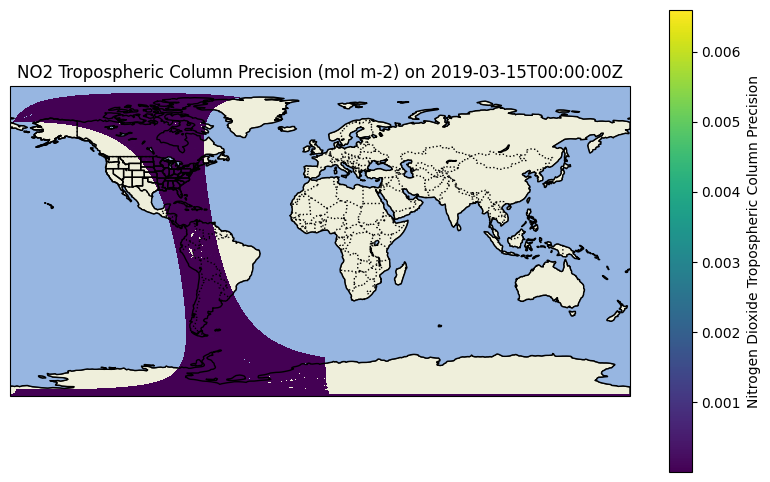

In [8]:
# Extract the variable and coordinates
no2_data = ds['PRODUCT_nitrogendioxide_tropospheric_column_precision'][0, :, :]
lons = ds['PRODUCT_longitude'][0, :, :]
lats = ds['PRODUCT_latitude'][0, :, :]

# Create a plot with a specific projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Use pcolormesh to handle the 2D nature of the data and coordinates, with the transform argument
mesh = ax.pcolormesh(lons, lats, no2_data, shading='auto', transform=ccrs.PlateCarree())

# Add a colorbar for reference
plt.colorbar(mesh, ax=ax, label='Nitrogen Dioxide Tropospheric Column Precision')

# Add map features
ax.coastlines()  # Add coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')  # Add country borders
ax.add_feature(cfeature.LAND, edgecolor='black')  # Add land
ax.add_feature(cfeature.OCEAN)  # Add oceans
ax.add_feature(cfeature.LAKES, edgecolor='black')  # Add lakes
ax.add_feature(cfeature.STATES)  # Add States

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NO2 Tropospheric Column Precision (mol m-2) on 2019-03-15T00:00:00Z')

# Show the plot
plt.show()


### 5. Calculate Area Averages for 2019

In [9]:
means_2019 = []
timestamps_2019 = []

bbox = [41.6, 42.1, -88.8, -87.5]

for link in opendap_link_subsets_2019:
    ds = xr.open_dataset(link)

    in_bbox = ((ds['PRODUCT_latitude'] >= bbox[0]) & (ds['PRODUCT_latitude'] <= bbox[1]) &
               (ds['PRODUCT_longitude'] >= bbox[2]) & (ds['PRODUCT_longitude'] <= bbox[3]))

    in_bbox_collapsed = in_bbox.any(dim='PRODUCT_time')

    try:
        subset = ds['PRODUCT_nitrogendioxide_tropospheric_column_precision'].where(in_bbox_collapsed, drop=True)
        means_2019.append(subset.mean().values.item())
        timestamps_2019.append(ds.attrs['time_reference'])
    except:
        means_2019.append(np.nan)
        timestamps_2019.append(None)  # Use None or a placeholder for missing timestamps


### 6. Create Separate Query for 2020

On March 20th, 2020, Governor Pritzker announced a stay-at-home order: https://www.illinois.gov/news/press-release.21288.html

In [10]:
opendap_links_2020 = []

# Initialize the CMR search API
api = cmr.GranuleQuery()

# Define the time range
start_time = "2020-03-15T00:00:00Z"
end_time = "2020-04-01T23:59:59Z"

# Search for granules with the specific short name, version, time range, and bounding box
granules = (
    api.short_name('S5P_L2__NO2____HiR')
    .version('2')
    .temporal(start_time, end_time)
    .bounding_box(-88, 41.6, -87.5, 42.1) # Define the bounding box, over the Chicagoland area (0.5 deg x 0.5 deg)
    .get()
)

# Output the granules and their links
for granule in granules:
    opendap_link = None
    http_link = None
    # Find OPeNDAP links
    for link in granule.get('links', []):
        if 'href' in link:
            href = link['href']
            if 'opendap' in href and '.nc' in href:
                opendap_link = href
                opendap_links_2020.append(opendap_link)

opendap_link_subsets_2020 = []

for link in opendap_links_2020:
  opendap_link_subsets_2020.append(link + '?PRODUCT_nitrogendioxide_tropospheric_column_precision,PRODUCT_longitude,PRODUCT_latitude')

### 7. Calculate Area Averages for 2020

In [11]:
means_2020 = []
timestamps_2020 = []

for link in opendap_link_subsets_2020:
    ds = xr.open_dataset(link)

    in_bbox = ((ds['PRODUCT_latitude'] >= bbox[0]) & (ds['PRODUCT_latitude'] <= bbox[1]) &
               (ds['PRODUCT_longitude'] >= bbox[2]) & (ds['PRODUCT_longitude'] <= bbox[3]))

    in_bbox_collapsed = in_bbox.any(dim='PRODUCT_time')

    try:
        subset = ds['PRODUCT_nitrogendioxide_tropospheric_column_precision'].where(in_bbox_collapsed, drop=True)
        means_2020.append(subset.mean().values.item())
        timestamps_2020.append(ds.attrs['time_reference'])
    except:
        means_2020.append(np.nan)
        timestamps_2020.append(None)  # Use None or a placeholder for missing timestamps

### 8. Group Days and Calculate Daily Means

Because some swaths contain the same day, we need to group the values by each day of the year and calculate daily mean values by using Pandas DataFrames.

In [12]:
# Create dataframes
df_2019 = pd.DataFrame({'timestamp': timestamps_2019, 'mean': means_2019})
df_2020 = pd.DataFrame({'timestamp': timestamps_2020, 'mean': means_2020})

# Convert timestamps to datetime
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])
df_2020['timestamp'] = pd.to_datetime(df_2020['timestamp'])

# Create a month/day string for grouping
df_2019['month_day'] = df_2019['timestamp'].dt.strftime('%m-%d')
df_2020['month_day'] = df_2020['timestamp'].dt.strftime('%m-%d')

# Group by month/day and calculate the mean
df_2019_daily = df_2019.groupby('month_day')['mean'].mean()
df_2020_daily = df_2020.groupby('month_day')['mean'].mean()

# Merge the two dataframes on month_day
merged_df = pd.merge(df_2019_daily, df_2020_daily, left_index=True, right_index=True, suffixes=('_2019', '_2020'))
merged_df.reset_index(inplace=True)

merged_df.head()

,month_day,mean_2019,mean_2020
0,03-15,0.000039,0.000027
1,03-16,0.000022,0.000077
2,03-17,0.000024,0.000031
3,03-18,0.000058,0.000148
4,03-19,0.000089,0.000345


### 9. Create 2019/2020 Line Plots

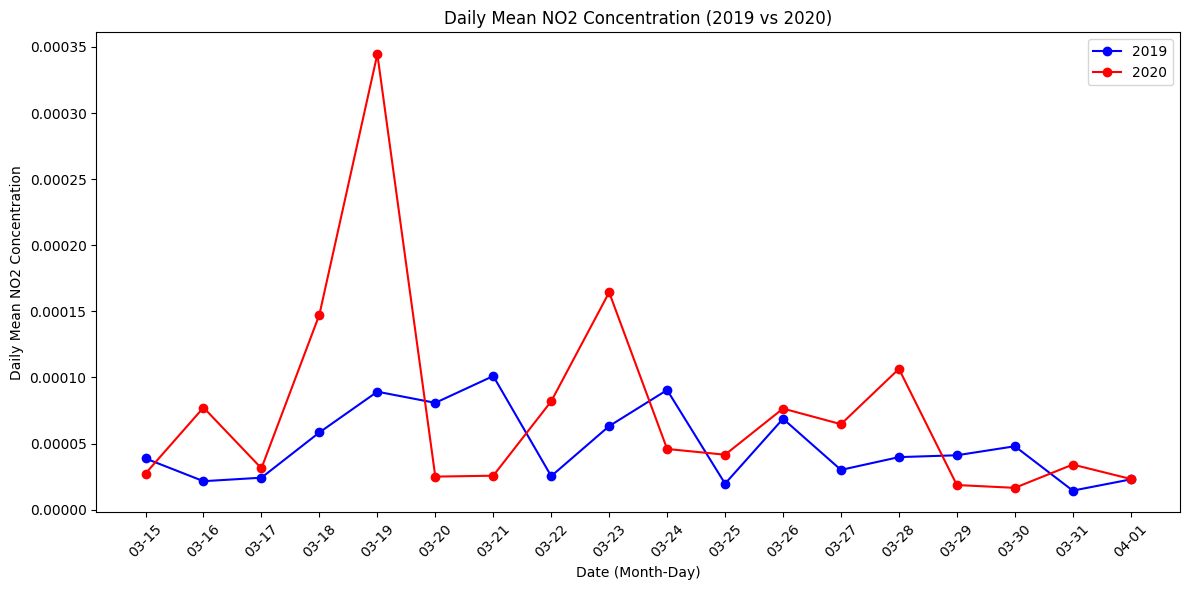

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['month_day'], merged_df['mean_2019'], label='2019', color='blue', marker='o')
plt.plot(merged_df['month_day'], merged_df['mean_2020'], label='2020', color='red', marker='o')
plt.xlabel('Date (Month-Day)')
plt.ylabel('Daily Mean NO2 Concentration')
plt.title('Daily Mean NO2 Concentration (2019 vs 2020)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()